# CatBoost Regressor 

### CatBoost, bir makine öğrenimi algoritmasıdır ve kategorik değişkenlerle çalışmak için özel olarak tasarlanmıştır. Kategorik değişkenler, metinsel veya kategorik değerlerden oluşan veri setindeki değişkenlerdir. CatBoost, özellikle sıralı kategorik değişkenleri ele almak için etkilidir.

### CatBoost, gradient boosting yöntemine dayanan bir algoritmadır. Gradient boosting, zayıf tahmincileri (genellikle karar ağaçları) birleştirerek güçlü bir tahminci oluşturmayı amaçlar. CatBoost, bu boosting sürecini kategorik değişkenlerin özel niteliklerini dikkate alarak gerçekleştirir.

## CatBoost'un başlıca özellikleri şunlardır:

### Kategorik Değişken Desteği: CatBoost, otomatik olarak kategorik değişkenleri tanır ve bu değişkenleri içsel olarak kodlar. Bu, veri bilimcilerin kategorik değişkenler üzerinde ayrı kodlama işlemleri yapmalarını gerektirmez.

### Sıralı Değişken Desteği: CatBoost, sıralı kategorik değişkenlerle çalışmak için özel olarak tasarlanmıştır. Örneğin, kullanıcı sıralama bilgilerini içeren bir veri seti varsa, CatBoost bu bilgileri kullanarak daha iyi tahminler yapabilir.

### Hızlı Eğitim ve Tahmin: CatBoost, hızlı ve ölçeklenebilir bir algoritmadır. Paralel işleme yetenekleri sayesinde büyük veri setlerinde etklili bir şekilde çalışabilir.

### İyi Performans: CatBoost, genellikle diğer popüler boosting algoritmalarıyla karşılaştırıldığında iyi bir performans gösterir. Genel olarak, tahmin doğruluğunu arttırmak için diğer algoritmaların ihtiyaç duyduğu bazı hiperparametre ayarlarını da otomatik olarak gerçekleştirir.

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [78]:
# Veri setini oluşturalım.
np.random.seed(42)
data = {
    'Öğrenci': np.random.choice(['Ali', 'Ayşe', 'Mehmet', 'Fatma', 'Ahmet'], size=100),
    'Yaş': np.random.randint(17, 21, 100),
    'Cinsiyet': np.random.choice(['Erkek', 'Kadın'], size=100),
    'Sınıf': np.random.choice([10, 11, 12], size=100),
    'Matematik': np.random.randint(75, 95, size=100),
    'Fizik': np.random.randint(75, 95, size=100),
    'Kimya': np.random.randint(75, 95, size=100)
}

data = pd.DataFrame(data)
data.head()

,Öğrenci,Yaş,Cinsiyet,Sınıf,Matematik,Fizik,Kimya
0,Fatma,20,Erkek,12,92,76,92
1,Ahmet,19,Erkek,10,84,94,89
2,Mehmet,17,Kadın,10,77,84,86
3,Ahmet,20,Erkek,11,82,93,83
4,Ahmet,20,Erkek,12,88,75,84


# Veri Analizi

In [79]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Yaş,100.0,18.54,1.113916,17.0,17.75,19.0,19.00,20.0
Sınıf,100.0,10.91,0.842015,10.0,10.00,11.0,12.00,12.0
Matematik,100.0,84.45,5.929510,75.0,79.00,84.5,90.00,94.0
Fizik,100.0,84.64,6.002558,75.0,79.00,85.0,90.00,94.0
Kimya,100.0,84.75,5.553004,75.0,80.00,85.0,89.25,94.0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Öğrenci    100 non-null    object
 1   Yaş        100 non-null    int32 
 2   Cinsiyet   100 non-null    object
 3   Sınıf      100 non-null    int32 
 4   Matematik  100 non-null    int32 
 5   Fizik      100 non-null    int32 
 6   Kimya      100 non-null    int32 
dtypes: int32(5), object(2)
memory usage: 3.6+ KB


In [81]:
data.corr()

,Yaş,Sınıf,Matematik,Fizik,Kimya
Yaş,1.000000,-0.012277,0.063772,-0.142851,0.079200
Sınıf,-0.012277,1.000000,0.129582,-0.114395,0.174445
Matematik,0.063772,0.129582,1.000000,-0.095583,0.100392
Fizik,-0.142851,-0.114395,-0.095583,1.000000,-0.051820
Kimya,0.079200,0.174445,0.100392,-0.051820,1.000000


In [82]:
data.var(numeric_only=True)

Yaş           1.240808
Sınıf         0.708990
Matematik    35.159091
Fizik        36.030707
Kimya        30.835859
dtype: float64

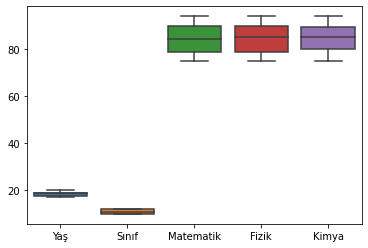

In [83]:
sns.boxplot(data=data);

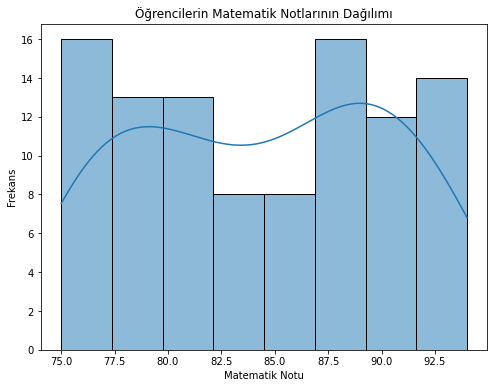

In [84]:
# Öğrencilerin matematik notlarının dağılımı
plt.figure(figsize=(8, 6))
sns.histplot(data['Matematik'], kde=True)
plt.title('Öğrencilerin Matematik Notlarının Dağılımı')
plt.xlabel('Matematik Notu')
plt.ylabel('Frekans')
plt.show()

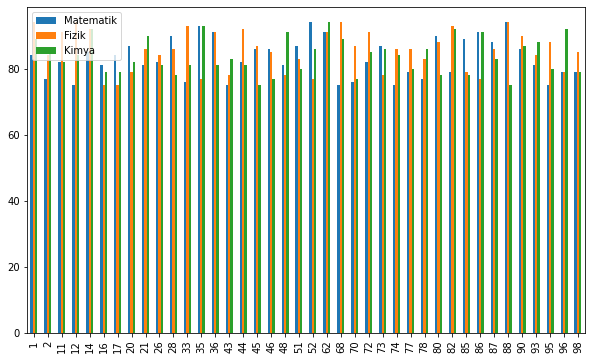

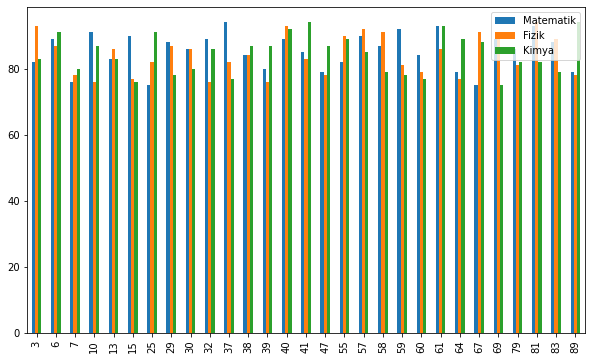

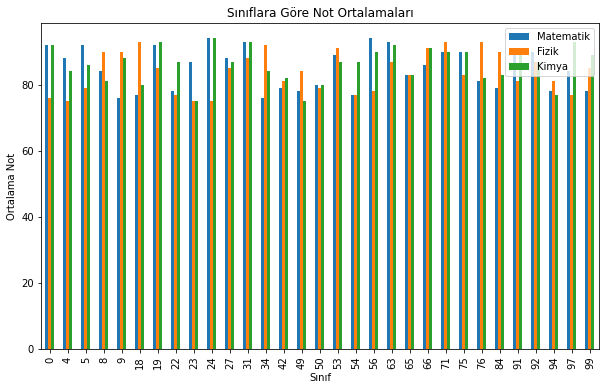

In [85]:
# Sınıflara göre ortalama notlar
data.groupby('Sınıf')[['Matematik', 'Fizik', 'Kimya']].plot(kind='bar', figsize=(10, 6))
plt.legend(loc='upper right')
plt.title('Sınıflara Göre Not Ortalamaları')
plt.xlabel('Sınıf')
plt.ylabel('Ortalama Not')
plt.show()

# Model 

In [86]:
# Bağımlı ve bağımsız değişkenleri oluşturalım.
X = data.drop('Matematik', axis=1)
y = data['Matematik']

In [87]:
# Eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Modeli kuralım ve eğitelim.
categorical_features = ['Cinsiyet', 'Öğrenci']
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, cat_features=categorical_features)
model.fit(X_train, y_train, verbose=False)

In [89]:
# Tahmin
predict = model.predict(X_test)

In [90]:
# Modeli Değerlendirelim.
r2 = r2_score(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = np.sqrt(mse)

print('R^2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

R^2:  0.1661534273308859
MSE:  27.35016758354694
RMSE:  5.229738768193584


In [91]:
result = pd.DataFrame({
    'Gerçek Değerler': y_test,
    'Tahmini Değerler': predict
})
result.head()

,Gerçek Değerler,Tahmini Değerler
83,88,83.722810
53,89,81.778443
70,76,83.885828
45,86,85.685439
44,82,84.009419
